<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Spring 2022<br>
            Dr. Eric Van Dusen <br>
        Notebook by Daniel Hammer & Peter F. Grinde-Hollevik</p></td></tr>
</table>

# Bay Area Onroad Emission Analysis
## Environmental Week Lecture Notebook

The **objective** of this lecture notebook is to examine cyclicality in time series analysis using emissions data. More specifically, we focus on city level emissions from [this *Nature* paper](https://www.nature.com/articles/s41467-020-20871-0) and the [associated *NYTimes* article](https://www.nytimes.com/2021/02/02/climate/cities-greenhouse-gas-emissions.html).

The **new tools** we apply are [GeoPandas](https://geopandas.org) and [Statsmodels Time Series Decomposition](https://www.statsmodels.org/dev/user-guide.html#time-series-analysis). 

In [239]:
import pandas
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Preparing data
This section is optional and will not be covered in lecture. I am just preparing a dataset, since the original, hourly dataset is over 500MB.

In [59]:
df = pandas.read_csv("hourly.csv", dtype={"GEOID10": str})

In [60]:
cities = {
    "Fresno": "31843",
    "Bay Area": "78904",
    "Santa Rosa": "79498",
    "Los Angeles": "51445",
    "San Diego": "78661",
    "Antioch": "02683"
}

subset = df[df.GEOID10.isin(cities.values())]
subset = subset[subset.date < "2016-01-01"]

In [63]:
subset.to_csv("daily_subset.csv", index=False)

## Decomposing time series
The subset of data includes daily emissions data for 10 sectors for 6 urban areas in California.

### Describing the data

In [78]:
df = pandas.read_csv(
    "daily_subset.csv", 
    dtype={"GEOID10": str}
)

set(df.Sector)

{'Total',
 'airport',
 'cement',
 'cmv',
 'commercial',
 'elec_prod',
 'industrial',
 'nonroad',
 'onroad',
 'rail',
 'residential'}

In [90]:
df.head()

,GEOID10,Sector,date,emissions
0,02683,Total,2015-01-01,1458.838074
1,02683,Total,2015-01-02,1788.375873
2,02683,Total,2015-01-03,1416.535039
3,02683,Total,2015-01-04,1033.511089
4,02683,Total,2015-01-05,1524.953008


In [93]:
agg_df = df.groupby("Sector")["emissions"].sum()
agg_df/agg_df.max()

Sector
Total          1.000000
airport        0.023518
cement         0.000000
cmv            0.002613
commercial     0.095782
elec_prod      0.054881
industrial     0.096016
nonroad        0.185902
onroad         0.460419
rail           0.000400
residential    0.080471
Name: emissions, dtype: float64

These are **Scope 1** emissions.  These are direct emissions, not emissions associated with, for example, energy imported from outside of the boundaries of urban areas. This is one reason why residential or industrial emissions seem so low, relative to the onroad -- emissions direct from tailpipes within the urban area extent.  

First, consider the total daily emissions in 2015 for the Bay Area.  The spatial extent of the Census-defined urban areas are not totally clear.  Map the boundaries using a Pandas extension for geographic data, called GeoPandas.  The primary difference between Pandas and GeoPandas is the addition of a `geometry` variable.

In [109]:
# !pip install geopandas
import geopandas

### [cleanup] Mapping the data 
*Preparation for class.* We will just use the GeoJSON file, so we don't have to review an antiquated file format and a very large file.  Note also that Github automatically renders GeoJSON files stored in the code repository as a web map.  This is pretty helpful for exploration without code.

In [119]:
# Download and read in urban area data `cb_2018_us_ua10_500k.zip`
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
# note that you will need to have the .shx, .dbf, and .shp file in the same directory
gdf = geopandas.read_file("cb_2018_us_ua10_500k.shp")
subset = gdf[gdf.GEOID10.isin(cities.values())]
subset[["GEOID10", "geometry"]].to_file("urban_areas.geojson", driver='GeoJSON')

### Mapping the data

In [120]:
gdf = geopandas.read_file("urban_areas.geojson")
gdf.head()

,GEOID10,geometry
0,02683,"MULTIPOLYGON (((-121.65930 37.96882, -121.6568..."
1,78661,"MULTIPOLYGON (((-116.71106 32.84909, -116.7068..."
2,79498,"MULTIPOLYGON (((-122.77665 38.33810, -122.7740..."
3,51445,"MULTIPOLYGON (((-117.50582 34.15049, -117.5014..."
4,78904,"MULTIPOLYGON (((-122.19717 38.04922, -122.1971..."


The urban area defined by Census includes San Francisco along with the South, East, and North Bay.

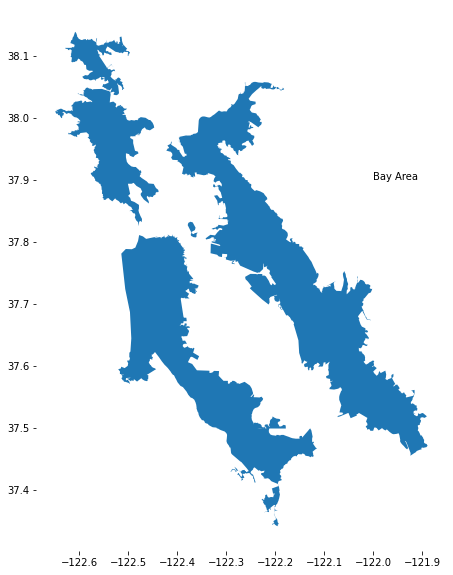

In [332]:
fig, ax = plt.subplots(figsize=(10,10))

gdf[gdf.GEOID10 == "78904"].plot(
    ax=ax
)

# an example of how to label polygons
plt.annotate(s="Bay Area", xy=[-122, 37.9])

# remove the default Matplotlib frame, which is IMHO excessive
plt.box(on=None) 

### Plotting total emissions
The most difficult part of plotting time series in Python is dealing with dates.  There are many facilities to help deal with dates and times in Python, but sometimes it's difficult to keep them all straight.  Another reason why pandas is a nice package &mdash; built-in methods to deal with this sort of thing.

In [136]:
total = df[df.Sector == "Total"]
total_bayarea = total[total.GEOID10 == cities["Bay Area"]]
total_bayarea

,GEOID10,Sector,date,emissions
16060,78904,Total,2015-01-01,22962.415759
16061,78904,Total,2015-01-02,24947.984489
16062,78904,Total,2015-01-03,20965.136237
16063,78904,Total,2015-01-04,18246.133569
16064,78904,Total,2015-01-05,22003.032291
...,...,...,...,...
16420,78904,Total,2015-12-27,19301.551790
16421,78904,Total,2015-12-28,20805.251904
16422,78904,Total,2015-12-29,24020.521065
16423,78904,Total,2015-12-30,24238.840420


What day of the week has, on average, the highest level of onroad emissions?  For this, we need to decompose the timeseries into its cyclical, trend, and residual components. We use the `statsmodel` package to help us.

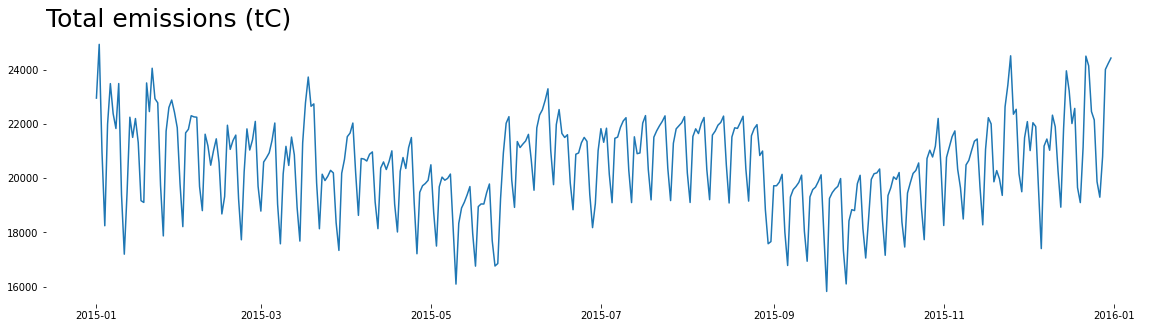

In [157]:
# create a variable, external to the dataframe, which 
date = pandas.to_datetime(total_bayarea.date)

# set the size and define the axes for future reference
fig, ax = plt.subplots(figsize=(20,5))

# set the figure title
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html
plt.title(
    "Total emissions (tC)", 
    loc="left", 
    fontdict={'fontsize': 25}
)

# suppress the returned information from the plot with a throwaway assignment to `_`
_ = ax.plot(date, total_bayarea.emissions)

# remove the default Matplotlib frame, which is IMHO excessive
plt.box(on=None)

,GEOID10,Sector,date,emissions
18980,78904,onroad,2015-01-01,7337.937131
18981,78904,onroad,2015-01-02,7690.017190
18982,78904,onroad,2015-01-03,6269.980237
18983,78904,onroad,2015-01-04,5564.723068
18984,78904,onroad,2015-01-05,7200.408905
...,...,...,...,...
19340,78904,onroad,2015-12-27,5807.424586
19341,78904,onroad,2015-12-28,5618.843721
19342,78904,onroad,2015-12-29,7178.892082
19343,78904,onroad,2015-12-30,7017.412487


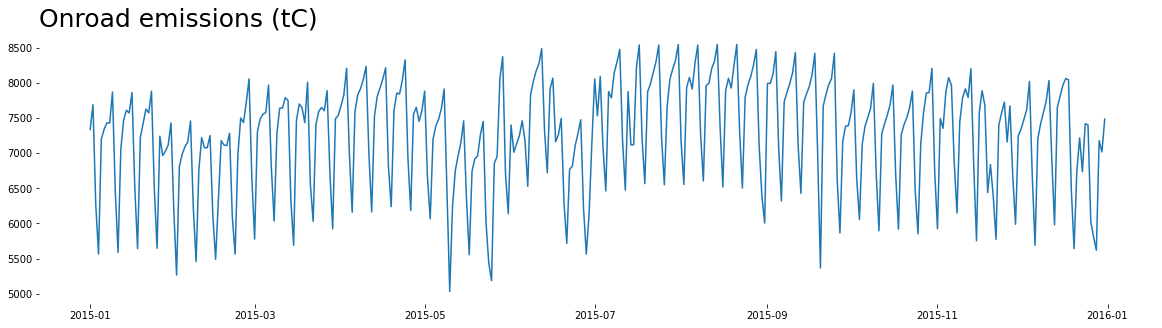

In [189]:
# filter the dataframe for onroad emissions in the Bay Area
onroad = df[df.Sector == "onroad"]
onroad_bayarea = onroad[onroad.GEOID10 == cities["Bay Area"]]

# set the size and define the axes for future reference
fig, ax = plt.subplots(figsize=(20,5))

# set the figure title
plt.title(
    "Onroad emissions (tC)", 
    loc="left", 
    fontdict={'fontsize': 25}
)

# suppress the returned information from the plot with a throwaway assignment to `_`
_ = ax.plot(date, onroad_bayarea.emissions)

# remove the default Matplotlib frame, which is IMHO excessive
plt.box(on=None)

### Decompose time series
We can decompose a time series into its seasonal, trend, and residual components.  The process is not too far off from fitting an ordinary least squares line. The value at each time period $t$ is defined as:

$$
y_ t = S_t + T_t + r_t
$$

We will rely on a package in the [`statsmodels`](https://www.statsmodels.org/stable/index.html) library called [`seasonal_decompose`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).  The `statsmodels` package is also useful for reporting the results from simple regressions.  The `seasonal_decompose` function accepts a simple dataframe with a date index.

In [334]:
# create a dataframe specifically for timeseries analysis
tsdf = onroad_bayarea[["emissions", "date"]]

# convert the date string to a date object
tsdf["date"] = pandas.to_datetime(tsdf.date)

# set the index of the time series data frame
tsdf = tsdf.set_index("date")
tsdf.head()

,emissions
date,
2015-01-01,7337.937131
2015-01-02,7690.017190
2015-01-03,6269.980237
2015-01-04,5564.723068
2015-01-05,7200.408905


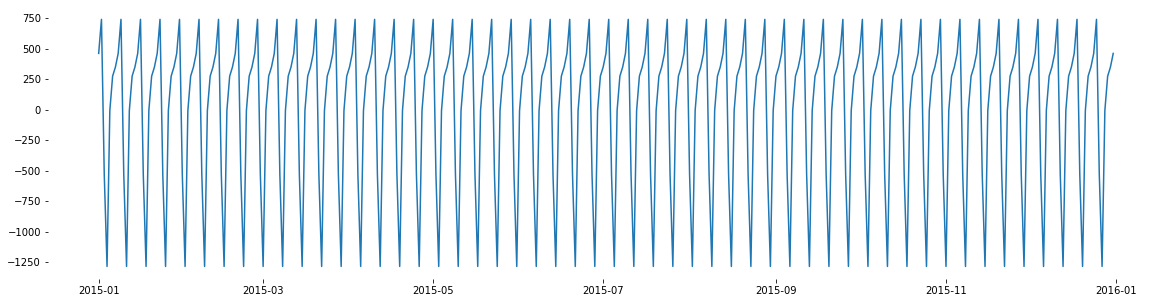

In [340]:
from statsmodels.tsa.seasonal import seasonal_decompose

# the default model is the one before, with an inferred periodicity.
a = seasonal_decompose(tsdf)

# this will give the same results, a natural periodicity of 7 days (1 week)
a = seasonal_decompose(tsdf, period=7)

### Seasonal Component

In [ ]:
# plot the seasonal component
fig, ax = plt.subplots(figsize=(20, 5))
_ = ax.plot(a.seasonal.index, a.seasonal)
plt.box(on=None)

### Trend Component

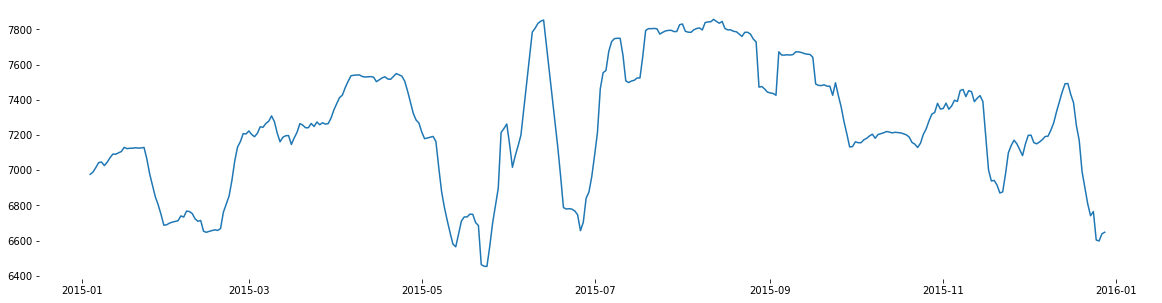

In [341]:
# plot the trend component
fig, ax = plt.subplots(figsize=(20, 5))
_ = ax.plot(a.trend.index, a.trend)
plt.box(on=None)

### Residual Component

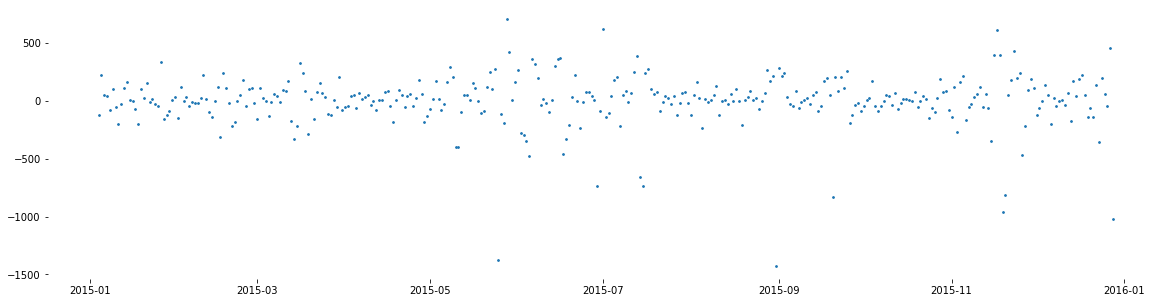

In [349]:
# plot the residual component
fig, ax = plt.subplots(figsize=(20, 5))
_ = ax.scatter(a.resid.index, a.resid, s=3)
plt.box(on=None)

### Unexpectedly High Emissions

Find those days with *unexpectedly high emissions*, given the trend and day of the week.

In [288]:
# 2015-01-01 --> Thursday
print(a.seasonal.head(n=10))

date
2015-01-01     460.744881
2015-01-02     739.914853
2015-01-03    -529.789532
2015-01-04   -1285.793355
2015-01-05      -7.903351
2015-01-06     274.113107
2015-01-07     348.713396
2015-01-08     460.744881
2015-01-09     739.914853
2015-01-10    -529.789532
Name: seasonal, dtype: float64


date
2015-05-28    703.146623
2015-07-01    623.979503
2015-11-17    614.053189
2015-12-27    454.895249
Name: resid, dtype: float64


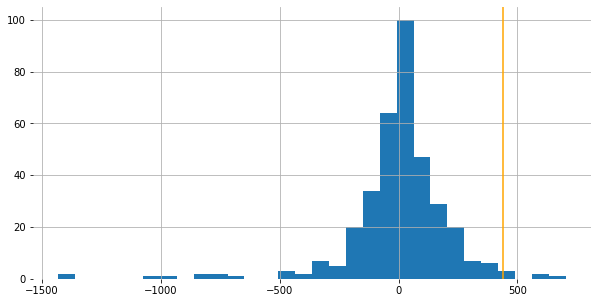

In [351]:
fig, ax = plt.subplots(figsize=(10,5))

# plot histogram of residuals
a.resid.hist(ax=ax, bins=30)

# add a vertical line at (roughly) the 99th percentile of the empirical distribution
plt.axvline(x=a.resid.quantile(0.99), color="orange")

# remove matplotlib frame
plt.box(on=None)

# which days had the unexpectedly highest emissions in absolute terms?
print(a.resid[a.resid > a.resid.quantile(0.99)])

* 2015-05-28 - Close to Memorial Day?
* 2015-07-01 - Day before Independence Day Off
* 2015-11-17 - Not sure about this one!
* 2015-12-27 - Driving back home again after Xmas?

### [Bonus] A full map of the area of interest

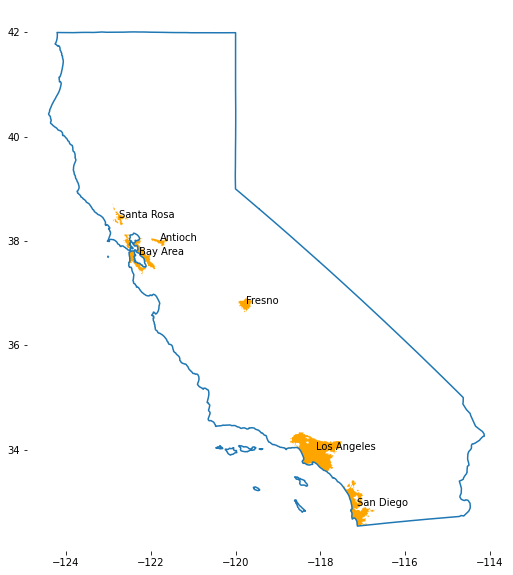

In [350]:
# read US map
us = geopandas.read_file("gz_2010_us_040_00_20m.geojson")
cali = us[us.NAME=="California"]

fig, ax = plt.subplots(figsize=(10,10))
plt.box(on=None) 
cali.boundary.plot(ax=ax)
gdf.plot(ax=ax, color="orange")

# reproduce the cities dictionary
cities = {
    "Fresno": "31843",
    "Bay Area": "78904",
    "Santa Rosa": "79498",
    "Los Angeles": "51445",
    "San Diego": "78661",
    "Antioch": "02683"
}

# swap keys and values for a dictionary
r_cities = {v: k for k,v in cities.items()}

# create a new variable that is the centroid of the polygons
gdf["centroid"] = gdf.geometry.centroid

# label the urban areas 
for idx, row in gdf.iterrows():
    [[x, y]] = row.centroid.coords
    plt.annotate(
        s=r_cities[row['GEOID10']], 
        xy=[x, y]
    )